In [1]:
import os, sys
import importlib

import cv2
import medmnist
import numpy as np
import pandas as pd
import torch.utils.data as data
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from tqdm import tqdm
from medmnist import INFO, Evaluator

sys.path.insert(0, os.path.abspath("../../hi-ml/src"))
sys.path.insert(0, os.path.abspath("../../hi-ml-azure/src"))

import histopathology.datamodules.panda_module as panda_module
from histopathology.models.transforms import LoadTilesBatchd

Failure while loading azureml_run_type_providers. Failed to load entrypoint automl = azureml.train.automl.run:AutoMLRun._from_run_dto with exception (cloudpickle 2.0.0 (/home/t-kbouzid/miniconda3/envs/HimlHisto/lib/python3.7/site-packages), Requirement.parse('cloudpickle<2.0.0,>=1.1.0'), {'azureml-dataprep'}).


## Load pathmnist 

In [2]:
data_flag = 'pathmnist'
download = True
BATCH_SIZE = 16
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

In [3]:
data_transform = transforms.Compose([
    transforms.ToTensor()
])
train_dataset = DataClass(split='train', transform=data_transform, download=download)

Using downloaded and verified file: /home/t-kbouzid/.medmnist/pathmnist.npz


In [4]:
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [5]:
sample, label = next(iter(train_loader))
sample.shape

torch.Size([16, 3, 28, 28])

In [6]:
train_dataset.montage(length=1)

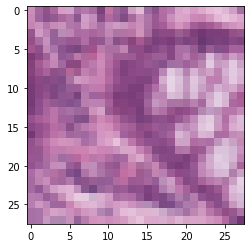

In [7]:
# img = cv2.merge((sample[0, 0], sample[0, 1], sample[0, 2]))
plt.imshow(np.transpose(sample[2], (1,2,0)))

In [8]:
channels, fill_val = 3, 25
n_patches, n_diag, patch_size = 2, 5, 28
img_size = n_patches * n_diag * patch_size
step_size = n_patches * patch_size

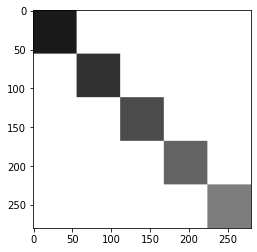

In [114]:
mock_image = np.full(shape=(channels, img_size, img_size), fill_value=255)
for i in range(n_diag):
    mock_image[:, step_size * i:step_size * (i+1), step_size * i:step_size * (i+1)] = fill_val * (i+1)
plt.imshow(np.transpose(mock_image, (1,2,0)))

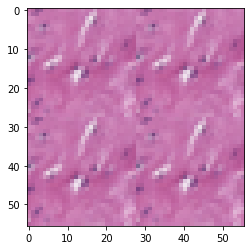

In [115]:
plt.imshow(np.transpose(np.tile(sample[2], (2, 2)), (1,2,0)))

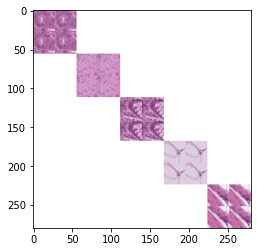

In [9]:
mock_image = np.full(shape=(channels, img_size, img_size), fill_value=1, dtype=np.float64)
for i in range(n_diag):
    mock_image[:, step_size * i:step_size * (i+1), step_size * i:step_size * (i+1)] = np.tile(sample[i], (2, 2))
plt.imshow(np.transpose(mock_image, (1,2,0)))

## Save mock as tiff file

### Test with pylibtiff

In [11]:
from libtiff import TIFFfile, TIFFimage, TIFF
from scipy import ndimage

In [12]:
ndimage.zoom(mock_image, (1, 2, 2)).shape

(3, 560, 560)

In [13]:
data = [mock_image, ndimage.zoom(mock_image, (1, 2, 2))]

In [15]:
tiff = TIFFimage(mock_image, description="")
tiff.write_file('mock2.tiff', compression='lzw') # or 'lzw'

Writing TIFF records to mock2.tiff
  filling records:   100% done (7Mi+934Ki+63 bytes/s)   
  resized records: 1Mi+815Ki+819 bytes -> 224Ki+353 bytes (compression: 8.28x)


8.275352502924697

In [16]:
tif = TIFFfile('mock.tiff')
samples, sample_names = tif.get_samples()

In [17]:
len(samples)

1

In [18]:
samples[0].shape

(3, 280, 280)

In [145]:
sample_names

['sample0']

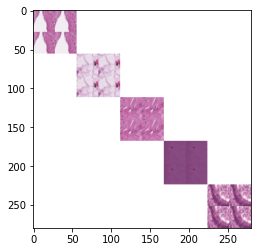

In [19]:
plt.imshow(np.transpose(samples[0], (1,2,0)))

In [161]:
dt = np.dtype(dict(names=list('rgb'), formats=[np.uint8]*3))
image = np.zeros((2, 3), dtype=dt)
image['r'][:, 0] = 250
image['g'][:, 1] = 251
image['b'][:, 2] = 252

In [163]:
arr = np.zeros((5, 6, 4), np.uint8)
for i in np.ndindex(*arr.shape):
    arr[i] = 20 * i[0] + 10 * i[1] + i[2]
print(arr.shape)

(5, 6, 4)


## Test with Tiffile package